In [1]:
import numpy as np
import networkx as nx

from matplotlib import pyplot as plt
from functools import cmp_to_key

---
загрузка графа:

In [240]:
W = None

# path = './example1.graphml'
path = './flow-test-3-piston.graphml'
G = nx.read_graphml(path)

---
алгоритм топологической сортировки:

In [241]:
def topsort(G):
    
    n = len(G)
    G_rev = nx.DiGraph.reverse(G)
    
    labels = dict(zip(list(G.nodes), [n + 1] * n))
    unprocessed_nodes = set(G.nodes)
    
    for i in range(n):
        adj_labels = []
        
        for j in unprocessed_nodes:
            adj_labels_j = []
            
            # вычисляем множество лейблов входящих вершин в вершину j
            for v in G_rev.neighbors(j):
                adj_labels_j.append(labels[v])
            adj_labels_j = sorted(adj_labels_j)[::-1]
            adj_labels.append((adj_labels_j, j))
        
        
        # находим вершину с минимальным множеством входящих лейблов
        _, v = sorted(adj_labels)[0]
        
        # присваеваем ей очередной номер и удаляем из очереди на обработку
        labels[v] = i
        unprocessed_nodes.remove(v)
    
    return labels

---
добавление фиктивных вершин:

In [242]:
def order_x(G):
    cnt_k = 0
    for v in G.nodes:
        cnt_k = max(cnt_k, G.nodes[v]['pos'][1])
    
    cnt_layers = [0] * cnt_k
    for v in G.nodes:
        _, y = G.nodes[v]['pos']
        G.nodes[v]['pos'] = (cnt_layers[y - 1], y)
        cnt_layers[y - 1] += 1
    return G

def add_dummies(G):
    
    dummies_cnt = 0
    while True:
        changed = False
        for u, v in G.edges:
            if G.nodes[u]['pos'][1] - G.nodes[v]['pos'][1] > 1:
                changed = True
                G.remove_edge(u, v)
                for i in range(G.nodes[v]['pos'][1] + 1, G.nodes[u]['pos'][1]):
                    cur_v = 'd' + str(dummies_cnt)
                    G.add_node(cur_v)
                    G.nodes[cur_v]['pos'] = (0, i)
                    prev_v = (v if i == G.nodes[v]['pos'][1] + 1 else 'd' + str(dummies_cnt - 1))
                    G.add_edge(cur_v, prev_v)
                    dummies_cnt += 1
                G.add_edge(u, 'd' + str(dummies_cnt - 1))
                break
        
        if not changed:
            break
    
    return order_x(G)

---
алгоритм Коффмана-Грэхема:

In [243]:
def coffman_graham(G, W):
    
    n = len(G)
    attrs = {}
    
    # получаем номера из топологической сортировки
    labels = topsort(G)
    
    unprocessed_nodes = set(G.nodes)
    cur_y = 1
    cur_x = 1
    
    for i in range(n):
        
        # сначала пытаемся найти вершину, которую можно уложить на текущий слой
        # при этом имеющую максимальную метку среди подходящих
        idx = None
        for j in unprocessed_nodes:
            ok = True
            this_layer = True
            for v in G.neighbors(j):
                if v in unprocessed_nodes:
                    ok = False
                elif attrs[v]['pos'][1] == cur_y:
                    this_layer = False
            
            # ok - индикатор того, что все дети вершины уже обработаны
            if ok and this_layer and (idx == None or labels[j] > labels[idx]):
                idx = j
        
        # ищем просто подходящую вершину на следующий слой с максимальной меткой
        this_layer = True
        if idx == None:
            this_layer = False
            for j in unprocessed_nodes:
                ok = True
                for v in G.neighbors(j):
                    if v in unprocessed_nodes:
                        ok = False

                # ok - индикатор того, что все дети вершины уже обработаны
                if ok and (idx == None or labels[j] > labels[idx]):
                    idx = j
        
        # idx - очередная вершина на обработку
        
        # проверяем, что все потомки лежат ниже текущего слоя  
        if not this_layer:
            cur_y += 1
            cur_x = 1
        
        # задаем координаты вершины
        attrs[idx] = {'pos': (cur_x, cur_y)}
        
        cur_x += 1
        if cur_x == W + 1:
            cur_y += 1
            cur_x = 1
        
        # удаляем вершину из очереди на обработку
        unprocessed_nodes.remove(idx)
            
    nx.set_node_attributes(G, attrs)
    return G

---
алгоритм минимизации фиктивных вершин:

In [244]:
def dummy_vertices_minimization(G):
    G = coffman_graham(G, W=len(G) + 1)
    G_rev = nx.DiGraph.reverse(G)
    
    while True:
        changed = False
        for v in G.nodes:
            cur_x, cur_k = G.nodes[v]['pos']
            min_k = 0
            max_k = len(G) + 1
            
            # находим отрезок уровней, на которые может быть помещена данная вершина
            cnt_in = 0
            cnt_out = 0
            for t in G_rev.neighbors(v):
                max_k = min(max_k, G.nodes[t]['pos'][1])
                cnt_in += 1
            for t in G.neighbors(v):
                min_k = max(min_k, G.nodes[t]['pos'][1])
                cnt_out += 1
            
            # сдвигаем вершину максимально вверх или максимально вниз
            new_k = cur_k
            if cnt_in > cnt_out:
                new_k = max_k - 1
            else:
                new_k = min_k + 1
            
            G.nodes[v]['pos'] = (cur_x, new_k)
            changed = (new_k != cur_k)
        
        if not changed:
            break
    
    return G

---
алгоритм минимизации числа пересечений:

In [245]:
def minimize_crossings(G):
    
    G_rev = nx.DiGraph.reverse(G)
    
    cnt_k = 0
    for v in G.nodes:
        cnt_k = max(cnt_k, G.nodes[v]['pos'][1])
    
    # первый слой отсавим как есть, для всех остальных упорядочим вершины по принципу медиан
    for i in range(cnt_k, 0, -1):
        vers = []
        xs = []
        for v in G.nodes:
            if G.nodes[v]['pos'][1] == i:
                vers.append(v)
                neighbors = []
                for t in G_rev.neighbors(v):
                    neighbors.append(G.nodes[t]['pos'][0])
                if len(neighbors) > 0:
                    xs.append(sorted(neighbors)[(len(neighbors) - 1) // 2])
                else:
                    xs.append(0)
            
        xs = sorted(list(zip(xs, vers)))
        cnt_x = 1
        
        for x, v in xs:
            G.nodes[v]['pos'] = (cnt_x, i)
            cnt_x += 1
    
    # для каждой пары вершин в каждом слое проверяем, можно ли уменьшить кол-во пересечений
    # путём перестановки этой пары
    while True:
        changed = False
        for i in range(2, cnt_k - 1):
            
            # Посчитаем текущее количество пересечений между слоями i-1, i, i+1
            cur_cnt_crs = 0
            for u, v in G.edges:
                if G.nodes[u]['pos'][1] != i + 1 and G.nodes[u]['pos'][1] != i:
                    continue
                for s, t in G.edges:
                    if G.nodes[s]['pos'][1] != G.nodes[u]['pos'][1]:
                        continue
                    xu, yu = G.nodes[u]['pos']
                    xv, yv = G.nodes[v]['pos']
                    xs, ys = G.nodes[s]['pos']
                    xt, yt = G.nodes[t]['pos']
                    
                    cur_cnt_crs += (xu < xs and xv > xt) or (xu > xs and xv < xt)
                    
            vers = []
            for v in G.nodes:
                if G.nodes[v]['pos'][1] == i:
                    vers.append(v)
            
            for a_idx in range(len(vers)):
                for b_idx in range(a_idx + 1, len(vers)):
                    a = vers[a_idx]
                    b = vers[b_idx]
                    
                    new_cnt_crs = 0
                    for u, v in G.edges:
                        if G.nodes[u]['pos'][1] != i + 1 and G.nodes[u]['pos'][1] != i:
                            continue
                        for s, t in G.edges:
                            if G.nodes[s]['pos'][1] != G.nodes[u]['pos'][1]:
                                continue
                            xu, yu = G.nodes[u if u not in [a, b] else (b if u == a else a)]['pos']
                            xv, yv = G.nodes[v if v not in [a, b] else (b if v == a else a)]['pos']
                            xs, ys = G.nodes[s if s not in [a, b] else (b if s == a else a)]['pos']
                            xt, yt = G.nodes[t if t not in [a, b] else (b if t == a else a)]['pos']
                            
                            new_cnt_crs += (xu < xs and xv > xt) or (xu > xs and xv < xt)
                    
                    if new_cnt_crs < cur_cnt_crs:
                        G.nodes[a]['pos'], G.nodes[b]['pos'] = G.nodes[b]['pos'], G.nodes[a]['pos']
                        changed = True
        
        if not changed:
            break
        
    return G

---
процесс обработки графа:

In [246]:
if not W is None:
    G_layered = coffman_graham(G, W=W)
    G_layered = add_dummies(G_layered)
else:
    G_layered = dummy_vertices_minimization(G)
    G_layered = add_dummies(G_layered)
    
G_final = minimize_crossings(G_layered)

---
отрисовка получившегося графа:

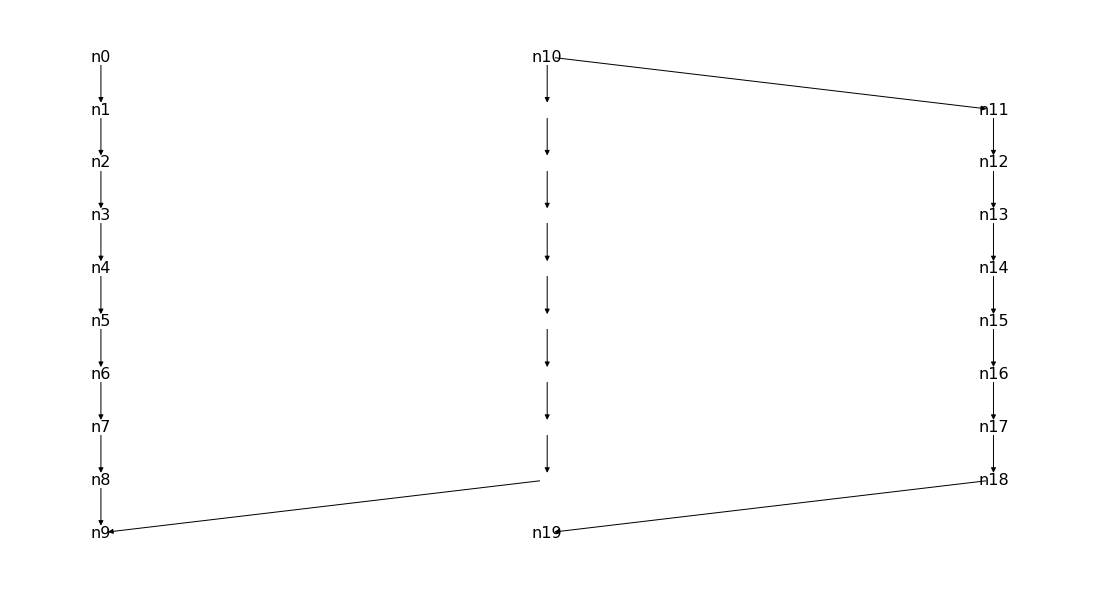

In [247]:
labels = {}

for v in G_final.nodes:
    if v[0] != 'd':
        labels[v] = v

plt.figure(figsize=(15, 8))
nx.draw(G_final, nx.get_node_attributes(G, 'pos'), labels=labels, node_size=200, node_color='w', font_size=16)
plt.savefig('result.png', format='png')
plt.draw()